In [1]:
%pip install langgraph langchain_teddynote langchain_core --no-cache-dir

Note: you may need to restart the kernel to use updated packages.


In [14]:
%pip install --upgrade langchain_teddynote
%pip install grandalf
%pip install --config-settings="--global-option=build_ext" \
  --config-settings="--global-option=-I/opt/homebrew/opt/graphviz/include/" \
  --config-settings="--global-option=-L/opt/homebrew/opt/graphviz/lib/" \
  pygraphviz


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached pygraphviz-1.14.tar.gz (106 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pygraphviz: filename=pygraphviz-1.14-cp311-cp311-macosx_11_0_arm64.whl size=91043 sha256=1671152028153099dc664b67ecb46a0d50f6619319dfc8ccc32a6df8f75079b8
  Stored in directory: /Users/0tae1/Library/Caches/pip/wheels/9c/5f/df/6fffd2a4353f26dbb0e3672a1baf070c124a1d74a5f9318279
Successfully built pygraphviz
Note: you may need to restart the kernel to use updated packages.


In [15]:
from typing import TypedDict, Annotated, List
from langchain_core.documents import Document
import operator

# Custom State 정의
class GraphState(TypedDict):
    context: Annotated[List[Document], operator.add]
    answer: Annotated[List[Document], operator.add]
    question: Annotated[str, 'user question']
    sql_query: Annotated[str, 'sql query']
    binary_score: Annotated[str, 'binary score yes or no']

In [16]:
def retrieve(state: GraphState) -> GraphState:
    # retrieve: 검색
    documents = "검색된 문서"
    return GraphState(context=documents)

def rewrite_query(state: GraphState) -> GraphState:
    # retrieve: 검색
    documents = "검색된 문서"
    return GraphState(context=documents)

def llm_gpt_execute(state: GraphState) -> GraphState:
    # retrieve: 검색
    answer = "GPT 생성된 답변"
    return GraphState(answer=answer)

def llm_claude_execute(state: GraphState) -> GraphState:
    # retrieve: 검색
    answer = "Claude 생성된 답변"
    return GraphState(answer=answer)

def sum_up(state: GraphState) -> GraphState:
    # retrieve: 검색
    answer = "결과 중합"
    return GraphState(answer=answer)

def relevance_check(state: GraphState) -> GraphState:
    return GraphState(binary_score="yes or no")

def decision(state: GraphState) -> str:
    """
    binary_score 값에 따라 재검색 또는 종료를 결정하는 함수입니다.
    
    Args:
        state (GraphState): 현재 상태
        
    Returns:
        str: "재검색" 또는 "종료" 결정값 반환
    """
    if state["binary_score"] == "no":
        return "재검색"
    return "종료"


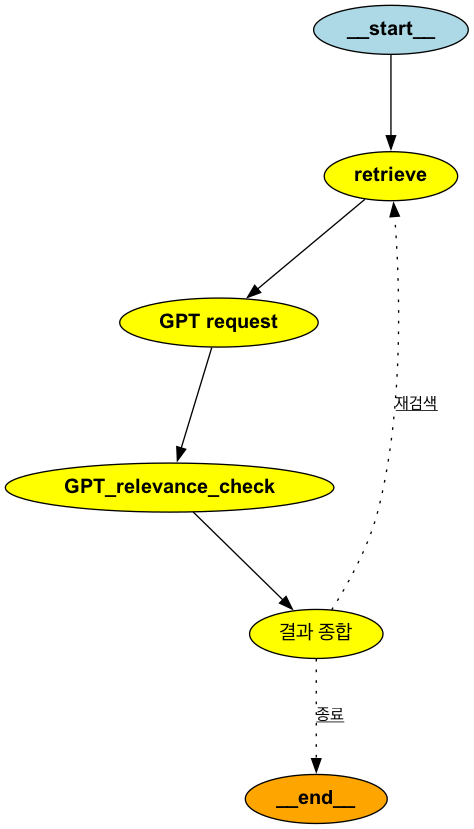

In [17]:
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_teddynote.graphs import visualize_graph


# (1): Conventinal Rag
# (2): 재검색
# (3): 멀티 LLM
# (4): 쿼리 재작성

# langgraph.graph에서 StateGraph와 End를 가져옵니다.
workflow = StateGraph(GraphState)
workflow.add_edge(START, "retrieve")

# 노드를 추가합니다.
workflow.add_node("retrieve", retrieve)

workflow.add_node("GPT request",llm_gpt_execute)

workflow.add_node("GPT_relevance_check", relevance_check)
workflow.add_node("결과 종합",sum_up)

# 각 노드들을 연결합니다.
workflow.add_edge("retrieve", "GPT request")

workflow.add_edge("GPT request", "GPT_relevance_check")

workflow.add_edge("GPT_relevance_check", "결과 종합")

# workflow.add_edge("결과 종합", END)

workflow.add_conditional_edges(
    "결과 종합",
    decision,
    {
        "재검색": "retrieve",
        "종료": END
    }
    
)

memory = MemorySaver()

app = workflow.compile(checkpointer=memory)


from IPython.display import Image
Image(app.get_graph().draw_png())
